## Setup

Import the required libraries and initialize them:

In [1]:
from std_srvs.srv import Empty

In [2]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [4]:
cv2.__version__


'3.3.1-dev'

In [5]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [6]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


In [7]:
#!python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation.py

In [8]:
#! python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation_backup.py



In [8]:

rospy.init_node("recognition")


In [10]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [9]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [12]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


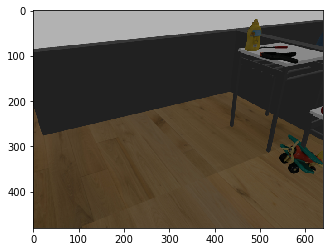

In [13]:
image= rgbd.get_image()
points_data= rgbd.get_points()
rospy.sleep(1)
plt.imshow(image)

In [14]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000): 
    image= rgbd.get_h_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this

            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
            
    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points))

In [15]:
seg_pca()

('cX,cY', 518, 78)
[ 0.7240573  -0.56200725  1.9087392 ]


(array([[ 0.7240573 , -0.56200725,  1.9087392 ]], dtype=float32),
 array([[[ 0.59379923, -0.86786044,  2.4116633 ],
         [ 0.58810896, -0.8552354 ,  2.3885527 ],
         [ 0.58252674, -0.84285   ,  2.365881  ],
         ...,
         [ 0.82446766, -0.3300831 ,  1.6411872 ],
         [ 0.8240044 , -0.32693893,  1.640265  ],
         [ 0.8241446 , -0.32403532,  1.640544  ]]], dtype=float32))

In [16]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)

# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node

def move_base(x,y,th, ref='map'):
    # input goal pose
    goal_x = x
    goal_y = y
    goal_yaw =th

    # fill ROS message
    goal = PoseStamped()
    goal.header.stamp = rospy.Time.now()
    goal.header.frame_id = ref
    goal.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    goal.pose.orientation = Quaternion(*quat)
    # publish ROS message
    pub.publish(goal)
    

In [17]:
arm.set_named_target('go')
arm.go()]

True

In [18]:
service_client = rospy.ServiceProxy('/tabletop_segmentator_node/execute', TabletopSegmentation)
service_client.wait_for_service(timeout=1.0)


In [19]:
move_base(1.5,1.13,.5*np.pi)

In [20]:

head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly

True

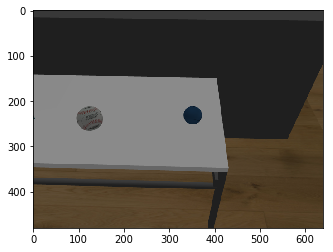

In [21]:
plt.imshow(rgbd.get_image())

# run this in terminal (TABLETOP SEGMENTATION )
#  rviz -d `rospack find hsrb_vision_samples`/config/tabletop.rviz

In [22]:

#define a tabletop segmentation request.
# Play with these parameters


req = TabletopSegmentationRequest()
req.crop_enabled = True  # limit the processing area
req.crop_x_max = 0.7     # X coordinate maximum value in the area [m]
req.crop_x_min = -0.7    # X coordinate minimum value in the area [m]
req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
req.crop_z_max = 1.1     # Z coordinate maximum value in the area [m]
req.crop_z_min = 0.0     # Z coordinate minimum value in the area [m]
req.cluster_z_max = 1.0  # maximum height value of cluster on table [m]
req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
req.remove_bg = True    # remove the background of the segment image

res = service_client(req)
for i in range (len(res.table_array.tables)):
    print (res.table_array.tables[i].pose)

rospy.loginfo('Number of detected objects={0}'.format(
    len(   res.segmented_objects_array.table_objects_array)))
rospy.loginfo('Number of detected planes={0}'.format(
    len(res.table_array.tables)))
#(trans,rot)=tf_listener.lookupTransform('hand_palm_link', 'map', rospy.Time(0)) 

position: 
  x: -0.000919040292501
  y: 0.337287813425
  z: 1.01900005341
orientation: 
  x: 0.924191534519
  y: -1.92500447156e-05
  z: -4.6581204515e-05
  w: 0.381929337978
position: 
  x: 0.0246120616794
  y: -0.235087618232
  z: 0.941000044346
orientation: 
  x: 0.924227654934
  y: 0.00558484019712
  z: -0.0135277416557
  w: -0.381561368704
position: 
  x: -0.156474962831
  y: 0.0119285844266
  z: 0.778000056744
orientation: 
  x: 0.925497710705
  y: -0.000126051032566
  z: -0.00030801052344
  w: 0.378753036261
position: 
  x: 0.0306016076356
  y: -0.36329600215
  z: 0.870000064373
orientation: 
  x: 0.926703393459
  y: -6.34153620922e-05
  z: -0.000156381676788
  w: 0.375793606043
[INFO] [1642178180.292557, 343.330000]: Number of detected objects=4
[INFO] [1642178180.294939, 343.331000]: Number of detected planes=4


In [23]:
objs_depth_centroids=[]
for i in range (len(res.segmented_objects_array.table_objects_array	)):
    print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
    for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
        cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
        cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[0] )
        pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
        points=np.zeros((pc.shape[0],3))
        points[:,0]=pc['x']
        points[:,1]=pc['y']
        points[:,2]=pc['z']
        objs_depth_centroids.append(np.mean(points,axis=0))
        print(i,j)
print objs_depth_centroids

#lets publish a tf to this centroids ( lot of false positives) !!!!


('Plane', 0, 'has', 3, 'objects')
(0, 0)
(0, 1)
(0, 2)
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 0, 'objects')
('Plane', 3, 'has', 0, 'objects')
[array([-0.07900613,  0.18087295,  0.74486023]), array([-0.25494206, -0.00227216,  0.72040232]), array([ 0.04237942, -0.01214461,  0.74813041])]


In [28]:
for i in range(len(objs_depth_centroids)):
    #Table is a plane at z=.8 So we consider false positives all the centroids outside the region on axis z ( .79 , .9)
    if objs_depth_centroids[i][2] > 0 and objs_depth_centroids[i][2] <44.9: 
        static_transformStamped = geometry_msgs.msg.TransformStamped()
        broadcaster.sendTransform((objs_depth_centroids[i]),(0,0,0,1), rospy.Time.now(), 'Closest_Object'+str(i),"head_rgbd_sensor_link")
        print (i,objs_depth_centroids[i][2])


(0, 0.7448602346915684)
(1, 0.7204023222418768)
(2, 0.7481304057666747)


In [29]:
def static_tf_publish(cents):
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0))
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan')
        else:
            broadcaster.sendTransform((x,y,z),rot, rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()
            

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            static_transformStamped.header.stamp = rospy.Time.now()
            static_transformStamped.header.frame_id = "map"
            
            static_transformStamped.transform.translation.x = float(xyz_map[0])
            static_transformStamped.transform.translation.y = float(xyz_map[1])
            static_transformStamped.transform.translation.z = float(xyz_map[2])
            #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
            static_transformStamped.transform.rotation.x = 0#-quat[0]#trans.transform.rotation.x
            static_transformStamped.transform.rotation.y = 0#-quat[1]#trans.transform.rotation.y
            static_transformStamped.transform.rotation.z = 0#-quat[2]#trans.transform.rotation.z
            static_transformStamped.transform.rotation.w = 1#-quat[3]#trans.transform.rotation.w
            if xyz_map[2] > .7 and xyz_map[2] < .85:
                static_transformStamped.child_frame_id = "Object_"+str(i)+"_Table_real_lab"
                tf_static_broadcaster.sendTransform(static_transformStamped)
                print xyz_map[2]
            
            
            if xyz_map[2] > .4 and xyz_map[2] < .46:   #table 1 
                static_transformStamped.child_frame_id = "Object_"+str(i)+"_Table_1"
                tf_static_broadcaster.sendTransform(static_transformStamped)
                print xyz_map[2]
            if  xyz_map[2] < .15:   #table 1 
                static_transformStamped.child_frame_id = "Object_"+str(i)+"_Floor"
                tf_static_broadcaster.sendTransform(static_transformStamped)
                print xyz_map[2]
    return True
    


    


In [30]:
static_tf_publish(objs_depth_centroids)

0.452247924348
0.439589732342


True

In [31]:
centroids,_=seg_pca()
centroids

('cX,cY', 184, 441)
[-0.2283115   0.35683358  0.99727494]
('cX,cY', 194, 368)
[-0.2468578   0.25129694  1.0760937 ]
('cX,cY', 537, 377)
[0.41257814 0.15816171 1.1027426 ]
('cX,cY', 349, 236)
[ 0.04296689 -0.00515764  0.7808879 ]
('cX,cY', 120, 243)
[-0.27360803  0.00422893  0.76044905]


array([[-0.2283115 ,  0.35683358,  0.99727494],
       [-0.2468578 ,  0.25129694,  1.0760937 ],
       [ 0.41257814,  0.15816171,  1.1027426 ],
       [ 0.04296689, -0.00515764,  0.7808879 ],
       [-0.27360803,  0.00422893,  0.76044905]], dtype=float32)

# Checkout your rviz. You should be able to see a tf marker on the centroids published above

## Now lets add some working surfaces of the collision world scene in moveit

In [35]:
def add_object(name, size, pose, orientation):
    p = PoseStamped()
    p.header.frame_id = "odom"       # "head_rgbd_sensor_link"
    
    p.pose.position.x = pose[0]
    p.pose.position.y = pose[1]
    p.pose.position.z = pose[2]

    p.pose.orientation.x = orientation[0] * np.pi
    p.pose.orientation.w = orientation[1] * np.pi

    scene.add_box(name, p, size)


def publish_scene():
    add_object("shelf", [1.5, 0.04, 0.4], [2.5, 4.7, 0.78], [0.5, 0.5])
    add_object("shelf1", [1.5, 0.04, 0.4], [2.5, 4.7, 0.49], [0.5, 0.5])
    add_object("shelf2", [1.5, 0.04, 0.4], [2.5, 4.7, 0.18], [0.5, 0.5])
    add_object("shelf_wall", [1, 1, 0.04], [2.5, 4.9, 0.5], [0.5, 0.5])
    add_object("shelf_wall1", [.04, 1, 0.4], [2.7, 4.9, 0.5], [0.5, 0.5])
    add_object("shelf_wall2", [.04, 1, 0.4], [1.8, 4.9, 0.5], [0.5, 0.5])
    
    add_object("table_big", [1.7, 0.13, 0.7], [0.95, 1.9, 0.34], [0.5, 0.5])
    add_object("table_small", [0.5, 0.01, 0.4], [0.1, 1.9, 0.61], [0.5, 0.5])
    add_object("table_tray", [0.65, 0.01, 0.7], [1.8, -0.65, 0.4], [0.5, 0.5])    
    return True

In [36]:
scene = moveit_commander.PlanningSceneInterface()
scene_pub = rospy.Publisher('planning_scene',
                                         moveit_msgs.msg.PlanningScene,
                                         queue_size=5)


In [37]:
publish_scene()


True

In [38]:
## robot to neutral pose
head.set_named_target('neutral')
head.go()

True

In [39]:
whole_body.set_workspace((-1,-1,5,5))
scene.remove_world_object()


In [40]:
## we already have a object pose belief. Let's take gripper to it
xyz_map,quat_map= listener.lookupTransform(  '/odom','Object_2_Table_1',rospy.Time(0))
xyz_map


[1.509061009903978, 1.764959396956673, 0.43958973234212423]

In [41]:
wb_p=whole_body.get_current_pose()
wb_p

header: 
  seq: 0
  stamp: 
    secs: 495
    nsecs: 151000000
  frame_id: "odom"
pose: 
  position: 
    x: 1.56583806333
    y: 1.26909129704
    z: 0.673016117059
  orientation: 
    x: -0.70706405046
    y: -0.0176130634671
    z: -0.706712360659
    w: 0.0175455930023

In [42]:
wb_p=whole_body.get_current_pose()
pose,quat=pose_2_np(wb_p)
tf.transformations.euler_from_quaternion(quat),pose
wb_t=wb_p
wb_t.pose.position.x= xyz_map[0]
wb_t.pose.position.y= xyz_map[1]
wb_t.pose.position.z=.5
wb_t.pose.orientation.w = 0.433
wb_t.pose.orientation.x = -0.589
wb_t.pose.orientation.y =  -0.429
wb_t.pose.orientation.z =  -0.529



In [43]:
#scene.remove_world_object()

whole_body.set_pose_target(wb_t)
whole_body.go()

False

In [44]:
clear_octo_client()


In [45]:
#scene.remove_world_object()

whole_body.set_pose_target(wb_t)
whole_body.go()

True

In [64]:
arm.set_named_target('go')
arm.go()

head.set_named_target('neutral')
head.go()

True

In [61]:
arm.get_current_pose()

header: 
  seq: 0
  stamp: 
    secs: 1634576089
    nsecs: 686543941
  frame_id: "odom"
pose: 
  position: 
    x: 0.26616484078
    y: -0.104967105746
    z: 0.785636180361
  orientation: 
    x: 0.55844119682
    y: -0.476828467316
    z: 0.461132203878
    w: 0.498131642237

In [67]:
wb_p=whole_body.get_current_pose()
pose,quat=pose_2_np(wb_p)
tf.transformations.euler_from_quaternion(quat),pose
wb_t=wb_p
#wb_t.pose.position.x= xyz_map[0]
#wb_t.pose.position.y= xyz_map[1]
#wb_t.pose.position.z=.8
wb_t.pose.orientation.w = 0.55
wb_t.pose.orientation.x = -0.47
wb_t.pose.orientation.y =  0.46
wb_t.pose.orientation.z =  .5



In [69]:
whole_body.set_pose_target(wb_t)
whole_body.go()

False

[WARN] [1634576329.728657]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.


In [18]:
sort_list

NameError: name 'sort_list' is not defined

In [40]:
cents= np.asarray(objs_depth_centroids)
norms= np.linalg.norm(cents,axis=1)
cents[np.argsort(-norms)], cents

(array([[ 0.20497664, -0.09361606,  0.98184101],
        [-0.37058958,  0.32604629,  0.84662878],
        [-0.24216753,  0.26763469,  0.75646812],
        [-0.15521452,  0.23096908,  0.76600203],
        [ 0.0675759 ,  0.2400879 ,  0.71437308],
        [ 0.21690061,  0.25146039,  0.67766818]]),
 array([[ 0.20497664, -0.09361606,  0.98184101],
        [ 0.0675759 ,  0.2400879 ,  0.71437308],
        [ 0.21690061,  0.25146039,  0.67766818],
        [-0.15521452,  0.23096908,  0.76600203],
        [-0.24216753,  0.26763469,  0.75646812],
        [-0.37058958,  0.32604629,  0.84662878]]))

In [41]:
np.argsort(-norms), norms

(array([0, 5, 4, 3, 1, 2]),
 array([1.00736843, 0.75666214, 0.75466043, 0.81498305, 0.83816315,
        0.98001179]))

In [23]:
np.concatenate((cents,cents.mean(axis=1)))

ValueError: all the input arrays must have same number of dimensions

In [31]:
cents.linalg.norm(axis=1).argsort()

AttributeError: 'numpy.ndarray' object has no attribute 'linalg'

In [29]:
cents

array([[ 0.21690061,  0.25146039,  0.67766818],
       [ 0.0675759 ,  0.2400879 ,  0.71437308],
       [-0.24216753,  0.26763469,  0.75646812],
       [-0.15521452,  0.23096908,  0.76600203],
       [-0.37058958,  0.32604629,  0.84662878],
       [ 0.20497664, -0.09361606,  0.98184101]])

In [13]:
cv2.__file__

'/opt/ros/melodic/lib/python2.7/dist-packages/cv2.so'

In [14]:
cv2.__version__

'3.3.1-dev'

In [11]:
msg_img=rospy.wait_for_message('/hsrb/head_rgbd_sensor/rgb/image_rect_color', Image, timeout=1)

ValueError: data_class [type] is not a message data class

In [10]:
img =Image()

ValueError: No image data found. Expecting filename, url, or data.

In [12]:
data = rospy.wait_for_message('/hsrb/head_rgbd_sensor/depth_registered/rectified_points', PointCloud2)

In [17]:
from sensor_msgs.msg import Image
msg_img=rospy.wait_for_message('/hsrb/head_rgbd_sensor/rgb/image_rect_color', Image, timeout=1)

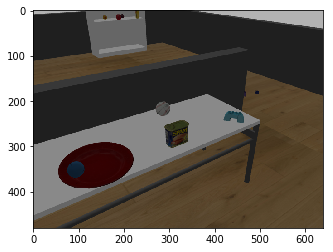

[WARN] [1645454046.570660, 629.593000]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.


In [25]:
from sensor_msgs.msg import Image
msg_img=rospy.wait_for_message('/hsrb/head_rgbd_sensor/rgb/image_rect_color', Image, timeout=1)
bridge= CvBridge()
img = bridge.imgmsg_to_cv2(msg_img,'rgb8')
plt.imshow(img)

In [15]:

Image()

header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
height: 0
width: 0
encoding: ''
is_bigendian: 0
step: 0
data: []